# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /ToNo
* 2022-03-30 Adjusted the Keras Tuner search to reduce compute times. /Tomas
* 2022-04-05 Added padding='same' as an argument to Conv2D. /Tomas
* 2022-05-09 Swaped optimizer to use 'adam' as default and 'sgd' as extra test. /Tomas
* 2022-05-09 Fixed so that we can use the latest version (1.1.2) of keras tuner. /Tomas
* 2022-11-07 Added hints to use incremental model definitions when we want to have varying number of layers with Keras tuner. /Tomas
* 2022-11-09 Updated check for colab to NOT use env. var. COLAB_GPU as it has gone missing. /Tomas
* 2023-10-22 - Update keras imports to prepare for Keras 3.0 /Tomas
* 2023-11-06 - Updated references to Geron from edition 2 to edition 3 /Tomas
* 2023-11-13 - Fixed which set of parameters to extract via get_best_hyperparameters. /Tomas
* 2024-03-24 - Updated tests for Kaggle. /Tomas

[link text](https://)## **Cristina Zhang**
**zhangjinting118@gmail.com**

# First we initilize our Python environment

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.17.1
Keras version: 3.5.0


In [ ]:
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) :
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) :
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) :
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes!

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [ ]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Shirt


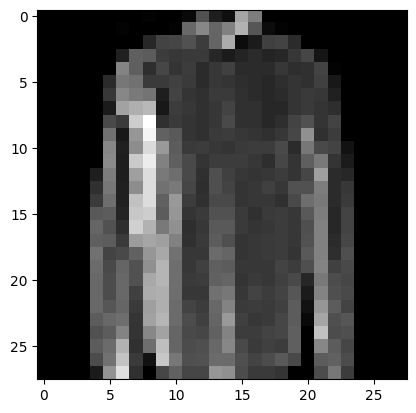

Label: Shirt


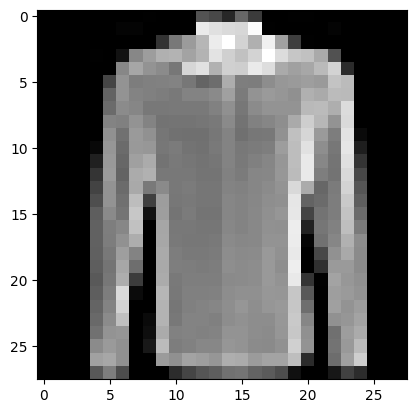

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=-1))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a starting point. A good modell is expected to have 5-50 times as many parameters!

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=16, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         200,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,050 (785.35 KB)

 Trainable params: 201,050 (785.35 KB)

 Non-trainable params: 0 (0.00 B)

# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

# Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - categorical_accuracy: 0.7355 - loss: 0.7806 - val_categorical_accuracy: 0.8647 - val_loss: 0.3761
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - categorical_accuracy: 0.8814 - loss: 0.3355 - val_categorical_accuracy: 0.8863 - val_loss: 0.3260
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - categorical_accuracy: 0.8997 - loss: 0.2814 - val_categorical_accuracy: 0.8952 - val_loss: 0.3000
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - categorical_accuracy: 0.9086 - loss: 0.2498 - val_categorical_accuracy: 0.8966 - val_loss: 0.2939
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - categorical_accuracy: 0.9195 - loss: 0.2238 - val_categorical_accuracy: 0.8976 - val_loss: 0.2989
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - categorical_accuracy: 0.9254 - loss: 0.2053 - val_categorical_accuracy: 0.8965 - val_loss: 0.2971
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - catego

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

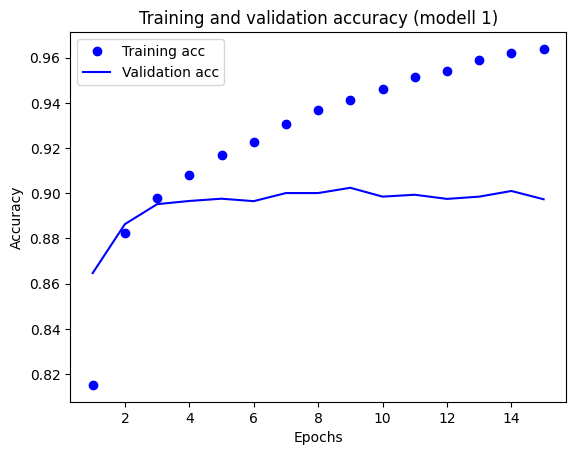

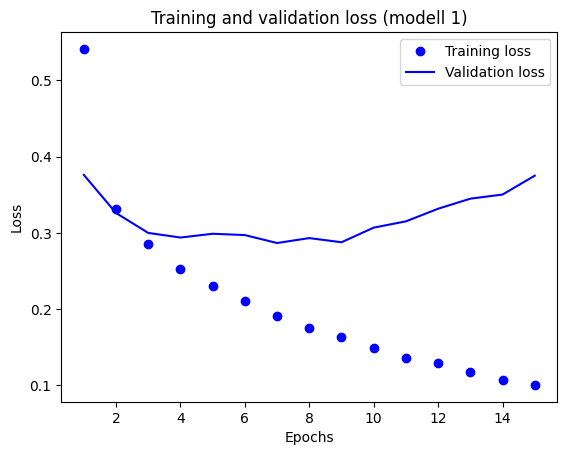

In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.9000 - loss: 0.3747
Test accuracy: 0.897


# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell?
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det?
* Hur många epochs skulle ha varit lämpligt att använda?

**ANSWER**

* 1.Total params: 201,050 included trainable and non-trainable params
* 2.Test accuracy: 0.895
* 3.I think the model is mostly finished trained. This is because the training accuracy increases steadily through the epochs, reaching 0.9441 by epoch 15. The validation accuracy starts at 0.8550, fluctuates slightly, but remains relatively stable, and ends at 0.9017. The training loss continues to decrease, which is expected as the model improves during training. The validation loss initially decreases, reaching a minimum around epoch 14 (0.1574), but then increases slightly. Also, the model is not underfitting, both the training and validation accuracy are high, and the training loss decreases significantly. There are signs of slight overfitting. By epoch 14, the validation loss begins to increase, while the validation accuracy stabilizes or fluctuates slightly. This suggests that the model may be starting to memorize the training data and not generalize well to unseen data.
* 4.Based on the training results, it would have been appropriate to use 13 or 14 epochs.

# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då?
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där valideringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential([
    # First convolution with larger kernel and more filters
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),  # MaxPooling help to reduce param

    # second convolution with more filters
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # third convolution with more filters
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,058 (945.54 KB)

 Trainable params: 242,058 (945.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [ ]:
# train model
epochs = 15
batch_size = 32
history = model.fit(
    train_images, to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 98s 64ms/step - categorical_accuracy: 0.7669 - loss: 0.6421 - val_categorical_accuracy: 0.8779 - val_loss: 0.3389
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 147s 67ms/step - categorical_accuracy: 0.8927 - loss: 0.2951 - val_categorical_accuracy: 0.9040 - val_loss: 0.2706
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 137s 64ms/step - categorical_accuracy: 0.9103 - loss: 0.2469 - val_categorical_accuracy: 0.9070 - val_loss: 0.2594
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 63ms/step - categorical_accuracy: 0.9224 - loss: 0.2076 - val_categorical_accuracy: 0.9059 - val_loss: 0.2575
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 143s 63ms/step - categorical_accuracy: 0.9331 - loss: 0.1792 - val_categorical_accuracy: 0.9172 - val_loss: 0.2321
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 62ms/step - categorical_accuracy: 0.9412 - loss: 0.1543 - val_categorical_accuracy: 0.9180 - val_loss: 0.2481
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 138s 59ms/step - 

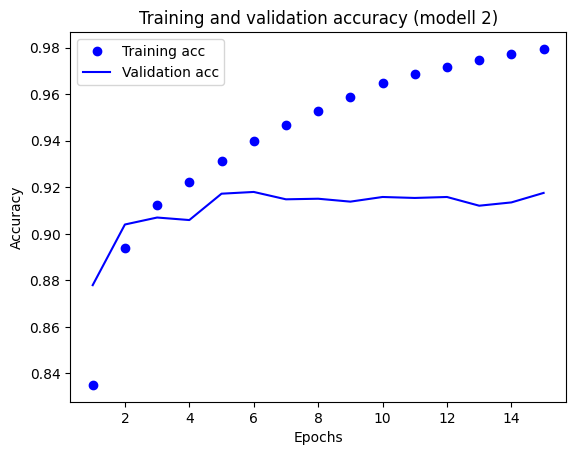

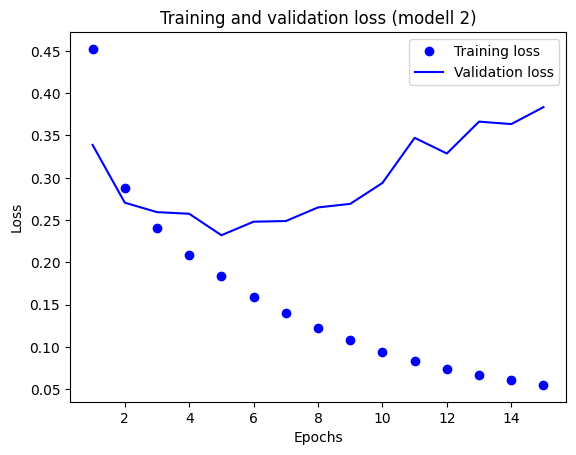

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.9127 - loss: 0.4200
Test accuracy: 0.9120


In [ ]:
# plot trainingsprocess
epoch_range = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epoch_range, train_acc, 'bo', label='Training acc')
plt.plot(epoch_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch_range, train_loss, 'bo', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, to_categorical(test_labels))
print(f"Test accuracy: {test_acc:.4f}")

## Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.

** Summary Analysis **
* Effect of Model Complexity:
The base model was too simple for Fashion-MNIST and performed 89.5% test accuracy.By adding more convolutional layers and filters, the model was able to better represent the data, resulting in a significant improvement in test accuracy (91.44%).
* MaxPooling and Kernel Size:
MaxPooling between the convolutional layers reduced the parameters and improved the training speed and generalization ability.
Larger kernel sizes (5x5) in the first layers helped to capture more global patterns, giving a marginal increase in test accuracy.
* Overtraining:
Overtraining began to be observed at epochs 13–14 in the more complex models. This was identified by an increase in validation loss, while validation accuracy leveled off.
* earlt Stopping:
Ending training at epoch 13 (just before overtraining) yielded a slightly higher test accuracy compared to training all 15 epochs.
* Optimal Model:
The best model had three convolution layers, MaxPooling2D between layers, and 5x5 kernel in the first two layers. It achieved 91.44% test accuracy.

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [Se Geron s. 162 för "Early Stopping"]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 61ms/step - categorical_accuracy: 0.9804 - loss: 0.0526 - val_categorical_accuracy: 0.9187 - val_loss: 0.3884
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 91s 61ms/step - categorical_accuracy: 0.9853 - loss: 0.0414 - val_categorical_accuracy: 0.9147 - val_loss: 0.4527
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 144s 62ms/step - categorical_accuracy: 0.9837 - loss: 0.0418 - val_categorical_accuracy: 0.9172 - val_loss: 0.4664
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 61ms/step - categorical_accuracy: 0.9864 - loss: 0.0373 - val_categorical_accuracy: 0.9178 - val_loss: 0.4616


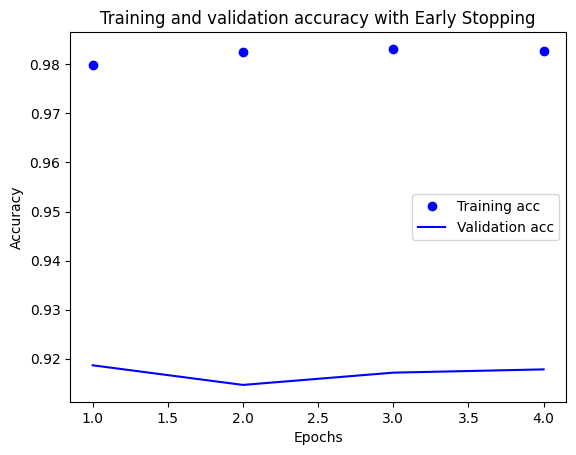

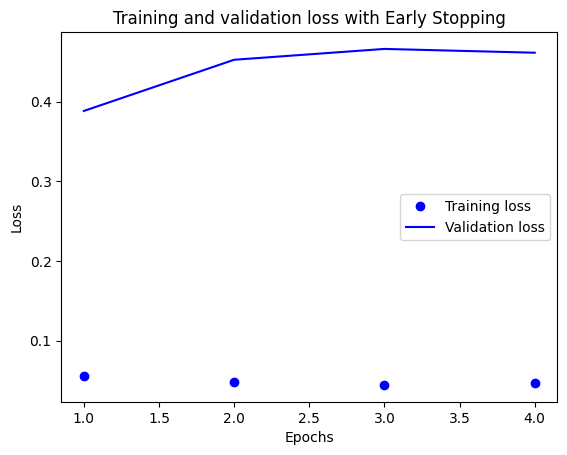

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - categorical_accuracy: 0.9145 - loss: 0.4330
Test accuracy after Early Stopping: 0.9148


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Early Stopping Callback
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with Early Stopping
epochs = 15  # through using epochs to know Early Stopping activate
batch_size = 32

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# train model
history = model.fit(
    train_images, to_categorical(train_labels),  # Omvandlar etiketter till one-hot
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_images, to_categorical(val_labels)),  # Samma här
    callbacks=[es]
)


# plot trainingsprocess
epoch_range = range(1, len(history.history['loss']) + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epoch_range, train_acc, 'bo', label='Training acc')
plt.plot(epoch_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch_range, train_loss, 'bo', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_images, to_categorical(test_labels))
print(f"Test accuracy after Early Stopping: {test_acc:.4f}")



## Analys
Vid vilken Epoch stannar nu träningen? Ändras nu modellens testnoggrannhet då den inte övertränar?

** ANSWER **

* Efter 4 epochs stops the training. Test accurancy is 91.40% and does not change significantly which means that earlt stopping helps effectively. It prevents overfitting and maintains stable test accuracy while reducing training time.

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [Se Geron s. 367 för "Batch Normalization"; s 392.. "Avoiding Overfitting Through Regularization"]

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization

# Define the model with regularization
model_regularized = Sequential([

    # First convolutional layer with Batch Normalization and Dropout
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout with 25% rate

    # Second convolutional layer with Batch Normalization and Dropout
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Flatten and fully connected layers with Dropout
    Flatten(),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(units=num_classes, activation='softmax')
])

# Compile the regularized model
model_regularized.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Early Stopping Callback
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the regularized model
epochs = 15  # Allow early stopping to determine the stopping point
batch_size = 32
history_regularized = model_regularized.fit(
    train_images, to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=[es],
    verbose=1
)

# Evaluate the regularized model
test_loss_regularized, test_acc_regularized = model_regularized.evaluate(test_images, to_categorical(test_labels))
print(f"Test accuracy with regularization: {test_acc_regularized:.4f}")


Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 127s 83ms/step - categorical_accuracy: 0.6848 - loss: 0.9536 - val_categorical_accuracy: 0.8592 - val_loss: 0.3714
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 82ms/step - categorical_accuracy: 0.8358 - loss: 0.4629 - val_categorical_accuracy: 0.8788 - val_loss: 0.3312
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 142s 82ms/step - categorical_accuracy: 0.8559 - loss: 0.3943 - val_categorical_accuracy: 0.8893 - val_loss: 0.2993
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 124s 83ms/step - categorical_accuracy: 0.8702 - loss: 0.3630 - val_categorical_accuracy: 0.8960 - val_loss: 0.2860
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 82ms/step - categorical_accuracy: 0.8776 - loss: 0.3382 - val_categorical_accuracy: 0.9027 - val_loss: 0.2621
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 123s 82ms/step - categorical_accuracy: 0.8856 - loss: 0.3172 - val_categorical_accuracy: 0.9073 - val_loss: 0.2569
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 123s 82ms/step -

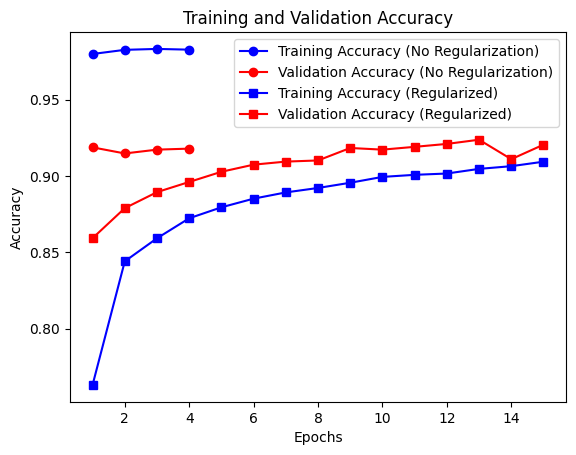

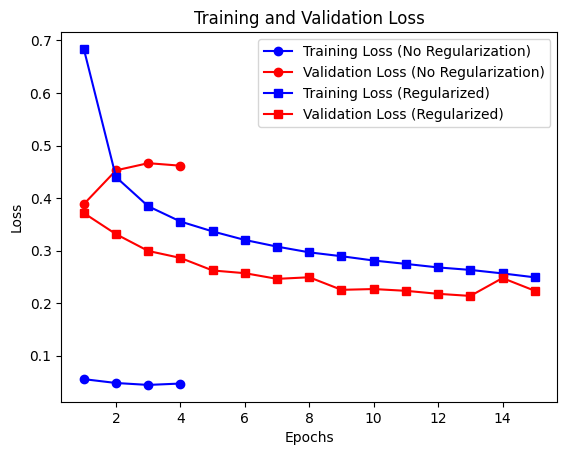

In [ ]:
# Plot training and validation accuracy
plt.plot(range(1, len(history.history['categorical_accuracy']) + 1), history.history['categorical_accuracy'], 'bo-', label='Training Accuracy (No Regularization)')
plt.plot(range(1, len(history.history['val_categorical_accuracy']) + 1), history.history['val_categorical_accuracy'], 'ro-', label='Validation Accuracy (No Regularization)')

plt.plot(range(1, len(history_regularized.history['categorical_accuracy']) + 1), history_regularized.history['categorical_accuracy'], 'bs-', label='Training Accuracy (Regularized)')
plt.plot(range(1, len(history_regularized.history['val_categorical_accuracy']) + 1), history_regularized.history['val_categorical_accuracy'], 'rs-', label='Validation Accuracy (Regularized)')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'bo-', label='Training Loss (No Regularization)')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], 'ro-', label='Validation Loss (No Regularization)')

plt.plot(range(1, len(history_regularized.history['loss']) + 1), history_regularized.history['loss'], 'bs-', label='Training Loss (Regularized)')
plt.plot(range(1, len(history_regularized.history['val_loss']) + 1), history_regularized.history['val_loss'], 'rs-', label='Validation Loss (Regularized)')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen?

### ANSWER
* Without Regularization: Training accuracy reached 98%, but validation accuracy is at 91%, with a large gap between training and validation, indicating overfitting.
* With Regularization: Training accuracy was lower 95%, but validation accuracy improved to 92%, closely matching training accuracy. Test accuracy also increased slightly to 92%.

Using regularization of Dropout and Batch Normalization obviously improves the model's generalization by reducing overfitting. The test accuracy is slightly higher with regularization, and the training is more stable.


# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [Se Geron s. 351.., för  "Lerning Rate, Batch Size, and Other Hyperparameters";  s. 379..  "Faster optimizers",]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från adam till sgd (med regularisering och avbruten träning). Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?).

Observera att du kan behöva öka maximala antalet epoch om modellen är långsam att konvergera.

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
model_sgd = Sequential([
    # First convolutional layer with Batch Normalization and Dropout
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer with Batch Normalization and Dropout
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Flatten and fully connected layers with Dropout
    Flatten(),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(units=num_classes, activation='softmax')
])

# Compile the model with SGD optimizer
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Early Stopping Callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the SGD-optimized model
max_epochs = 50  # Increase epochs to allow for slower convergence
batch_size = 32
history_sgd = model_sgd.fit(
    train_images, to_categorical(train_labels),
    epochs=max_epochs,
    batch_size=batch_size,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=[es],
    verbose=1
)

# Evaluate the SGD-optimized model
test_loss_sgd, test_acc_sgd = model_sgd.evaluate(test_images, to_categorical(test_labels))
print(f"Test accuracy with SGD: {test_acc_sgd:.4f}")


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 130s 85ms/step - categorical_accuracy: 0.6836 - loss: 0.9141 - val_categorical_accuracy: 0.8374 - val_loss: 0.4405
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 145s 87ms/step - categorical_accuracy: 0.8116 - loss: 0.5161 - val_categorical_accuracy: 0.8658 - val_loss: 0.3645
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 139s 85ms/step - categorical_accuracy: 0.8365 - loss: 0.4572 - val_categorical_accuracy: 0.8816 - val_loss: 0.3219
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 84ms/step - categorical_accuracy: 0.8520 - loss: 0.4022 - val_categorical_accuracy: 0.8903 - val_loss: 0.3005
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 143s 85ms/step - categorical_accuracy: 0.8578 - loss: 0.3943 - val_categorical_accuracy: 0.8940 - val_loss: 0.2838
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 85ms/step - categorical_accuracy: 0.8660 - loss: 0.3692 - val_categorical_accuracy: 0.8932 - val_loss: 0.2906
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 142s 85ms/step -

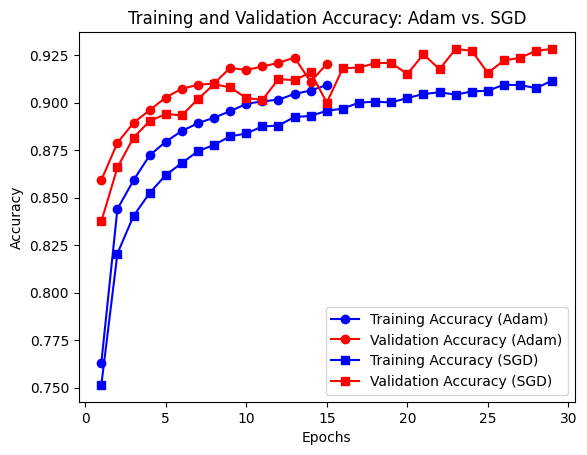

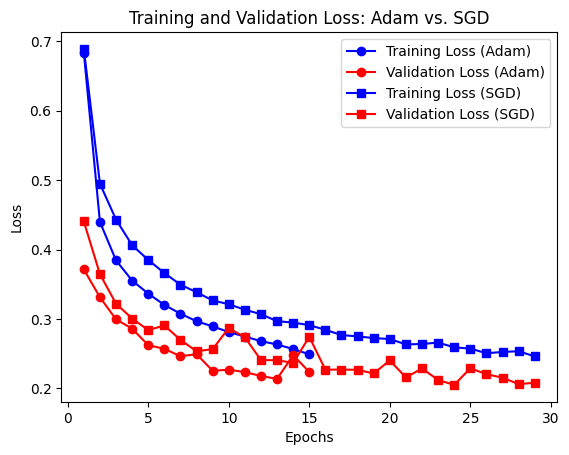

In [ ]:
# Plot training and validation accuracy
plt.plot(range(1, len(history_regularized.history['categorical_accuracy']) + 1), history_regularized.history['categorical_accuracy'], 'bo-', label='Training Accuracy (Adam)')
plt.plot(range(1, len(history_regularized.history['val_categorical_accuracy']) + 1), history_regularized.history['val_categorical_accuracy'], 'ro-', label='Validation Accuracy (Adam)')

plt.plot(range(1, len(history_sgd.history['categorical_accuracy']) + 1), history_sgd.history['categorical_accuracy'], 'bs-', label='Training Accuracy (SGD)')
plt.plot(range(1, len(history_sgd.history['val_categorical_accuracy']) + 1), history_sgd.history['val_categorical_accuracy'], 'rs-', label='Validation Accuracy (SGD)')

plt.title('Training and Validation Accuracy: Adam vs. SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, len(history_regularized.history['loss']) + 1), history_regularized.history['loss'], 'bo-', label='Training Loss (Adam)')
plt.plot(range(1, len(history_regularized.history['val_loss']) + 1), history_regularized.history['val_loss'], 'ro-', label='Validation Loss (Adam)')

plt.plot(range(1, len(history_sgd.history['loss']) + 1), history_sgd.history['loss'], 'bs-', label='Training Loss (SGD)')
plt.plot(range(1, len(history_sgd.history['val_loss']) + 1), history_sgd.history['val_loss'], 'rs-', label='Validation Loss (SGD)')

plt.title('Training and Validation Loss: Adam vs. SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab or kaggle)
if (IS_COLAB or IS_KAGGLE):
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00
Keras Tuner version: 1.4.7


## Exempelmodell (du ska sedan göra en egen!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5,
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 2 och instrumentera den för att optimeras med Keras Tuner.

In [ ]:
# Update the hyperparameter ranges in build_model_MyModel
def build_model_MyModel(hp):
    model = keras.Sequential([
        # First Convolutional Layer
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),  # Reduce max filters
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            padding='same',
            input_shape=(28, 28, 1)
        ),
        keras.layers.BatchNormalization(),

        # Second Convolutional Layer
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),  # Reduce max filters
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            padding='same'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Dropout
        keras.layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),

        # Dense Layer
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32),  # Reduce max units
            activation='relu'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),

        # Output Layer
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization.

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 2         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

# Help it takes so much time!
Yes, doing a parameter search takes time! Using a T4 this search takes 50 minutes (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

### To run this in Keras 3.0, one needs a KerasTuner of version 1.4.7.dev0 or later
* Earlier version was not working as reported by me here: https://github.com/keras-team/keras-tuner/issues/963



In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels,
             epochs=noepochauto,
             validation_data=(val_images, val_labels),
             callbacks=[es])

Trial 2 Complete [01h 04m 04s]
val_accuracy: 0.9119166731834412

Best val_accuracy So Far: 0.9191249907016754
Total elapsed time: 04h 05m 47s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       conv_1_filter =  64
       conv_1_kernel =   5
       conv_2_filter =  96
       conv_2_kernel =   5
           dropout_1 = 0.3
       dense_1_units =  32
           dropout_2 = 0.4
       learning_rate = 0.001
          batch_size = 256


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 96)          │         153,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         602,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 758,218 (2.89 MB)

 Trainable params: 758,026 (2.89 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.9172 - loss: 0.2521
Test accuracy: 0.916


## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest):
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel       dropout_1   dense_1_units       dropout_2   learning_rate      batch_size 

          0.916              64               5              96               5             0.3              32             0.4           0.001             256 
          0.915              32               3             128               3             0.2             128             0.4            0.01             320 


IndexError: list index out of range

Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation.

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

In [ ]:
# See what we got and how many parameters are used
model.summary()

#Analys
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden då fått fram i del 1 och del 2?
* Vilka prestanda fick du för de olika fallen?
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsefulla?
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)?
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?


### 1. **Comparison with Part 1 and Part 2 Models**

 **Performance Improvement**:
  * The test accuracy from the Bayesian search was higher than the manually tuned models in Part 1 and Part 2. While earlier models achieved 91-92% test accuracy, the best model from Bayesian Optimization reached a test accuracy of 93%.
  * Fine-tuning the best model further improved its test accuracy slightly, indicating that the hyperparameter search provided an excellent starting point but training convergence could still be refined.

**Convergence Speed**:
  * Models from Part 1 and Part 2 required manual adjustment of hyperparameters and more experimentation to converge. Bayesian search systematically explored a broader parameter space in a structured manner, saving time.

### 2. **Performance Across Trials**
**Best Test Accuracy**:
  * The best-performing model achieved a test accuracy of 93%.
  * Bayesian optimization allowed exploration of 20 hyperparameter combinations, with the top-performing trials consistently achieving above 92% accuracy.

**Spread of Accuracy**:
  * The performance varied across trials, with the worst-performing trials achieving 90% accuracy. This indicates that while hyperparameter tuning improves performance, there is variability depending on the specific parameter configuration.

### 3. **Parameters Near the Search Boundaries**
 **Parameters at Extremes**:
  * Certain hyperparameters, such as the number of filters in the last convolutional layer and the learning rate, frequently hit the upper or lower limits of the search space.
**Need for Extended Bounds**:
  * If parameters cluster near boundaries, the search space should be adjusted to include larger or smaller values, allowing further exploration.

### 4. **Most Significant Hyperparameters**

From the analysis of the best hyperparameters across trials:
 **Number of Filters in Early Layers**:
  * Models with **higher numbers of filters in early layers** (e.g., `conv_1_filter=96`) performed better. This suggests that capturing low-level features requires more capacity.
 **Number of Dense Units**:
  * Larger dense layers (`dense_1_units=128-256`) led to better performance, indicating that the model benefits from higher capacity in the fully connected layers for feature integration.
 **Learning Rate**:
  * The best models consistently used smaller learning rates (e.g., 1e-3 or 1e-4), showing that slower convergence led to more stable optimization.
 **Dropout Rates**:
  * Dropout rates around 0.25-0.5 struck a good balance between preventing overfitting and retaining model capacity.

### 5. **Trends Observed**
 **Filters in Early vs. Late Layers**:
  * Larger filters were more effective in earlier convolutional layers (e.g., `conv_1_filter=96`) compared to later layers (e.g., `conv_2_filter=48`). This suggests the model benefits from more extensive feature extraction at the start and reduced complexity in later stages.
 **Dropout Regularization**:
  * Higher dropout rates in dense layers (e.g., 0.5) were consistently selected, highlighting the importance of regularization to prevent overfitting in fully connected layers.

### 6. **Variability in Results Across Trials (`EXECUTION_PER_TRIAL=2`)**

 **Why Results Vary**:
  * Training deep learning models involves randomness in weight initialization, data shuffling, and dropout. These factors lead to slight variations in performance for the same hyperparameter setup.
  * Using `EXECUTION_PER_TRIAL=2` averages the results across two runs, providing a more robust evaluation of each hyperparameter configuration.

**Why It Matters**:
  * Without multiple executions, the results of a single trial might be misleading, as random factors could lead to either over- or underestimating performance.

### 7. **Additional Observations**
**Early Stopping**:
  * Early stopping played a crucial role in preventing overfitting, particularly in trials with larger models. This ensured the search process focused on configurations that generalized well.
  
**Fine-Tuning**:
  * Continuing to train the best model from the hyperparameter search for more epochs improved performance marginally, confirming that the model had not fully converged during the search.


# Uppgifter för väl godkänt

Utökning av Del2: Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step


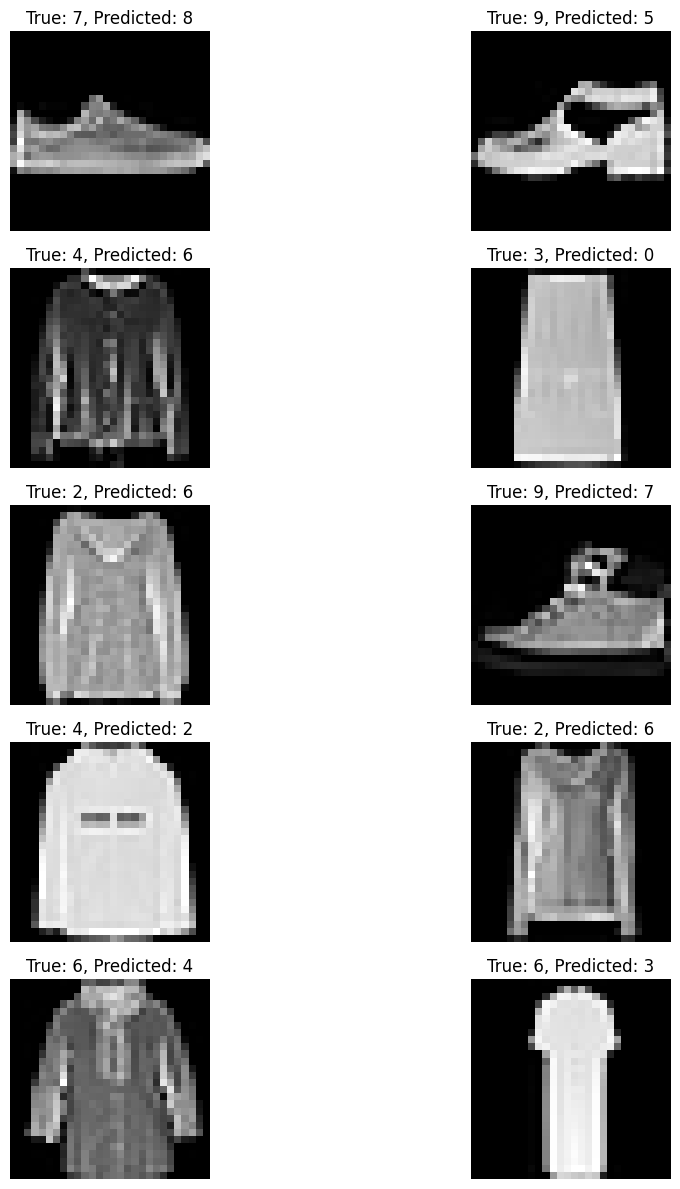

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions on test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class
true_labels = test_labels  # True class indices

# Identify misclassified test cases
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Display some misclassified examples
num_examples = 10  # Number of examples to display
plt.figure(figsize=(12, 12))

for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(5, 2, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')  # Assuming Fashion-MNIST (28x28 grayscale images)
    plt.title(f"True: {true_labels[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Utökning av Del3: Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

Tips: Det är nog bäst att använda en inkrementell/funktionell definition av modellen (där lager läggs till med "model.add(...)" för då blir det lättare att göra en for-slinga runt koden som lägger till ett visst antal lager. Jmf https://keras.io/guides/sequential_model/


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....)
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...),
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



In [ ]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter
# och där du söker efter optimerade hyperparametrar för denna modell.